In [1]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os


In [67]:
def get_sample_up_to_time(df, time_value):
    """
    Extracts a sample from the DataFrame from the start until the specified time_value.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing 'time_rel(sec)' and other data.
    time_value (float): The relative time value up to which the data should be sampled.

    Returns:
    pandas.DataFrame: A subset of the original DataFrame containing all rows up to time_value.
    """
    # Filter the DataFrame for rows where 'time_rel(sec)' is less than or equal to the given time_value
    sample = df[df['time_rel(sec)'] <= time_value]

    return sample

def get_sample_after_time(df, time_value):
    # Filter the DataFrame for rows where 'time_rel(sec)' is less than or equal to the given time_value
    sample = df[df['time_rel(sec)'] >= time_value]

    return sample

def get_time_rel_by_filename(df, filename):
    """
    Given a filename, this function returns the associated time_rel(sec) from the DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the filename and time_rel(sec) information.
    filename (str): The filename to search for.

    Returns:
    float: The time_rel(sec) associated with the given filename.
    """
    # Filter the DataFrame for the given filename
    row = df[df['filename'] == filename]

    # If the filename exists in the DataFrame, return the corresponding time_rel(sec)
    if not row.empty:
        return row['time_rel(sec)'].values[0]
    else:
        return None  # Return None if the filename is not found


In [68]:
# Example usage:
folder_path = './data/lunar/training/data/S12_GradeA/'  # Replace with your folder path
# datasets = load_csv_files_from_folder(folder_path)
dataset_files = []

label_dir = './data/lunar/training/catalogs/'
cat_file = label_dir + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

# print(datasets)
data_chunks_time_size = []
csv_train_files = cat['filename']

annomaly_quake = []

for _, csv_train_file_name in enumerate(csv_train_files):
    print(f"Loading file: {csv_train_file_name}")
    final_file_name = folder_path + csv_train_file_name + ".csv"
    
    try:
        ds = pd.read_csv(final_file_name)
    except FileNotFoundError as e:
        print(f"Did not find {csv_train_file_name}")
        
    time_value_for_cut = get_time_rel_by_filename(cat, csv_train_file_name)
    ds_sample = get_sample_up_to_time(ds, time_value_for_cut)
    dataset_files.append([csv_train_file_name, ds_sample])
    csv_time_list = ds_sample['time_rel(sec)'].tolist()
    data_chunks_time_size.append(len(csv_time_list))

    # Getting the "leftover" to store as anomalies
    annomaly = get_sample_after_time(ds, time_value_for_cut)
    annomaly_quake.append([csv_train_file_name, annomaly])

print(f"Loaded {len(dataset_files)} samples")

Loading file: xa.s12.00.mhz.1970-01-19HR00_evid00002
Loading file: xa.s12.00.mhz.1970-03-25HR00_evid00003
Loading file: xa.s12.00.mhz.1970-03-26HR00_evid00004
Loading file: xa.s12.00.mhz.1970-04-25HR00_evid00006
Loading file: xa.s12.00.mhz.1970-04-26HR00_evid00007
Loading file: xa.s12.00.mhz.1970-06-15HR00_evid00008
Loading file: xa.s12.00.mhz.1970-06-26HR00_evid00009
Loading file: xa.s12.00.mhz.1970-07-20HR00_evid00010
Loading file: xa.s12.00.mhz.1970-07-20HR00_evid00011
Loading file: xa.s12.00.mhz.1970-09-26HR00_evid00013
Loading file: xa.s12.00.mhz.1970-10-24HR00_evid00014
Loading file: xa.s12.00.mhz.1970-11-12HR00_evid00015
Loading file: xa.s12.00.mhz.1970-12-11HR00_evid00017
Loading file: xa.s12.00.mhz.1970-12-27HR00_evid00019
Loading file: xa.s12.00.mhz.1970-12-31HR00_evid00021
Loading file: xa.s12.00.mhz.1971-01-15HR00_evid00022
Loading file: xa.s12.00.mhz.1971-01-28HR00_evid00023
Loading file: xa.s12.00.mhz.1971-01-29HR00_evid00024
Loading file: xa.s12.00.mhz.1971-02-09HR00_evi

#### Seeing how Quakes happen in time

Trying to visualize if there is a time interval that quakes happen to define how many minutes or hours the data chunks will have.

Text(0.5, 1.0, 'xa.s12.00.mhz.1972-06-16HR00_evid00060')

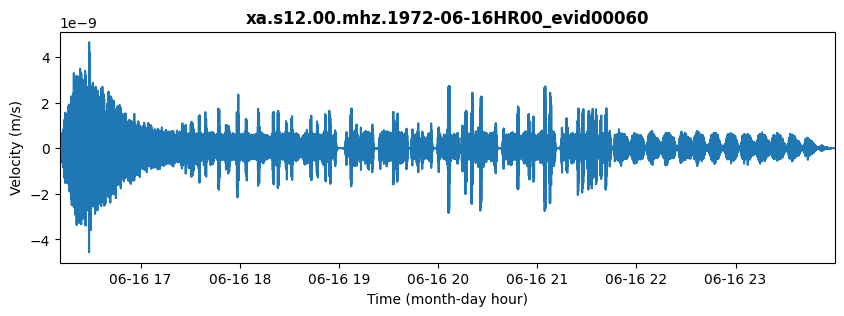

In [78]:
anom_indx = np.random.randint(len(annomaly_quake))
anom_filename, data_cat = annomaly_quake[anom_indx]

csv_times_dt = []
for absval_str in data_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].values:
    csv_times_dt.append(datetime.strptime(absval_str,'%Y-%m-%dT%H:%M:%S.%f'))

csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times_dt,csv_data)

# Make the plot pretty
ax.set_xlim((np.min(csv_times_dt),np.max(csv_times_dt)))
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (month-day hour)')
ax.set_title(f'{anom_filename}', fontweight='bold')

#### Calculating the mean and standard deviation to try to find an interval of data chunks

In [79]:
mean = np.mean(data_chunks_time_size)
std = np.std(data_chunks_time_size)
print(data_chunks_time_size)

print(f"Mean Time values for data cuts: {mean}")
print(f"Std Time values for data cuts: {std}")
print(f"Max value on time data cuts: {max(data_chunks_time_size)}")
print(f"Min value on time data cuts: {min(data_chunks_time_size)}")

[486938, 84271, 483758, 29416, 345428, 453151, 477398, 121636, 279841, 475808, 274673, 306076, 175696, 490516, 374048, 302101, 357353, 437648, 88246, 364906, 308063, 168541, 192788, 232538, 71551, 532651, 258773, 213458, 79103, 432481, 131176, 102158, 157013, 429301, 323963, 385973, 186826, 523111, 56843, 432481, 190006, 62806, 548948, 17491, 172913, 191198, 462293, 17491, 62806, 266326, 40546, 443611, 435263, 65986, 453946, 20671, 560873, 292958, 556898, 151448, 536626, 404656, 206701, 442816, 221806, 341056, 9143, 70358, 339466, 20671, 288188, 422543, 435263, 240488, 382793, 81091]
Mean Time values for data cuts: 277445.30263157893
Std Time values for data cuts: 166208.01984189474
Max value on time data cuts: 560873
Min value on time data cuts: 9143


(62806,)
Time Cut Shape: (62806,)
Time Full Shape: (572395,)


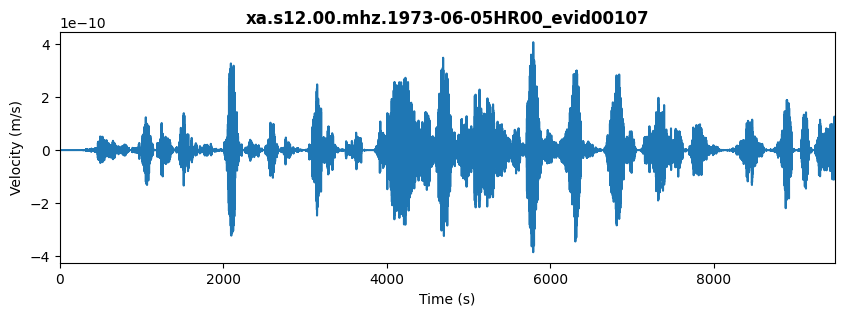

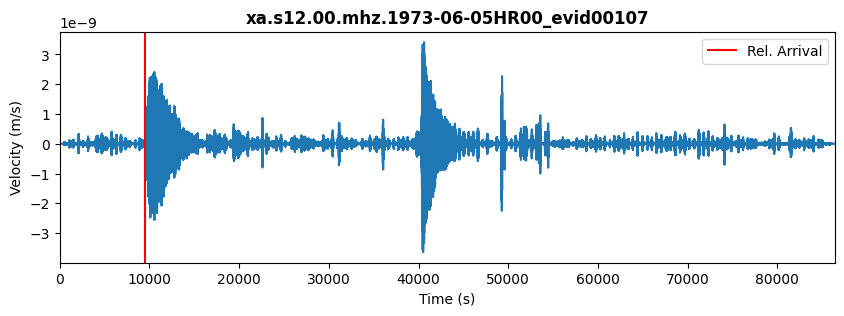

In [80]:
indx = np.random.randint(len(dataset_files))
test_filename, data_cat = dataset_files[indx]

csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())
print(csv_data.shape)
print(f"Time Cut Shape: {csv_times.shape}")

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

########

row = cat.iloc[indx]
test_filename= row.filename
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time_rel = row['time_rel(sec)']
data_directory = './data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)
# Plot the original for comparison
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())
print(f"Time Full Shape: {csv_times.shape}")

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])


#### Separating Dataset into Chunks with a fixed size for Neural Network Input
Chose an interval of 30min for each data chunk, the chunks with missing values will be filledd with the mean values corresponding to that chunk.

In [81]:
from tqdm import tqdm

def fill_missing_with_mean(df, chunk_size):
    """
    Fill a dataframe by adding rows at the end, with the velocity values close to the mean of the existing values,
    and incrementing the time_rel and time_abs columns accordingly.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    chunk_size (int): The desired chunk size.

    Returns:
    pd.DataFrame: A new dataframe with values close to the mean velocity added to match the chunk size.
    """
    # Calculate the number of missing values required to reach the chunk size
    missing_values = chunk_size - len(df)
    
    # Calculate the mean velocity of the existing data
    mean_velocity = df['velocity(m/s)'].mean()
    
    # Create new rows to fill the missing values
    last_time_rel = df['time_rel(sec)'].iloc[-1]
    last_time_abs = pd.to_datetime(df['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].iloc[-1])
    time_increment = df['time_rel(sec)'].diff().mean()  # Calculate average time difference between rows
    
    new_rows = []
    for i in range(missing_values):
        # Increment time_rel and time_abs accordingly
        new_time_rel = last_time_rel + time_increment * (i + 1)
        new_time_abs = last_time_abs + pd.Timedelta(seconds=time_increment * (i + 1))
        # Append the new row with time and mean velocity
        new_rows.append([new_time_abs.strftime('%Y-%m-%dT%H:%M:%S.%f'), new_time_rel, mean_velocity])
    
    # Create a new dataframe with the new rows
    new_df = pd.DataFrame(new_rows, columns=df.columns)
    # Concatenate the original dataframe with the new dataframe
    df_filled = pd.concat([df, new_df], ignore_index=True)
    
    
    return df_filled


def split_data_into_chunks(df, sampling_rate, chunk_duration, column_name='velocity(m/s)'):
    """
    Splits the velocity data in a DataFrame into chunks based on the sampling rate and chunk duration.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame containing the velocity data.
    sampling_rate (float): The sampling rate in Hz (e.g., 6.6 for 6.6 Hz).
    chunk_duration (float): The duration of each chunk in seconds (e.g., 1.0 for 1 second).
    column_name (str): The name of the column containing the velocity data (default is 'velocity(m/s)').
    
    Returns:
    list: A list of pandas DataFrames, where each DataFrame is a chunk of velocity data.
    """
    # Ensure the DataFrame is not empty
    if df.empty:
        print("DataFrame is empty!")
        return []
    
    # Calculate the number of samples per chunk
    samples_per_chunk = int(sampling_rate * chunk_duration)
    
    # Debugging information
    print(f"Total number of rows in DataFrame: {len(df)}")
    print(f"Samples per chunk: {samples_per_chunk}")
    
    # Check if the DataFrame has fewer rows than samples per chunk
    if len(df) < samples_per_chunk:
        print("Warning: The DataFrame has fewer rows than samples per chunk.")
        df = fill_missing_with_mean(df, samples_per_chunk)
        return [df]
    
    # Split the DataFrame into chunks
    chunks = [df.iloc[i:i + samples_per_chunk] for i in range(0, len(df), samples_per_chunk)]
    
    if len(chunks[-1]) < samples_per_chunk:
        # print("Removing incomplete last chunk.")
        # chunks.pop()
        print("Adding new values for incomplete last chunk.")
        chunks[-1] = fill_missing_with_mean(chunks[-1], samples_per_chunk)
    
    return chunks

# Example usage:
sampling_rate = 6.6  # 6.6Hz - sampling rate for the dataset
chunk_duration = 3600.0/2  # 30 minutes per chunk 3600s(1h)/2 = 30min

dataframes_for_training = []
with tqdm(total=len(dataset_files)) as pbar:
    for filename, dataframe in dataset_files:
        # print(filename, dataframe)
        # Split the DataFrame into 1-second chunks based on the velocity column
        chunks = split_data_into_chunks(dataframe, sampling_rate, chunk_duration, column_name='velocity(m/s)')
        # print(chunks)
        dataframes_for_training.append([filename, chunks])
        pbar.update(1)


  5%|███▎                                                            | 4/76 [00:00<00:02, 33.69it/s]

Total number of rows in DataFrame: 486938
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 84271
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 483758
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 29416
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 345428
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 453151
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 477398
Samples per chunk: 11880
Adding new values for incomplete last chunk.


 14%|█████████                                                      | 11/76 [00:00<00:02, 28.19it/s]

Total number of rows in DataFrame: 121636
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 279841
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 475808
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 274673
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 306076
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 175696
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 490516
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 374048
Samples per chunk: 11880
Adding new values for incomplete last chunk.


 29%|██████████████████▏                                            | 22/76 [00:00<00:01, 38.19it/s]

Total number of rows in DataFrame: 302101
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 357353
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 437648
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 88246
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 364906
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 308063
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 168541
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 192788
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 232538
Samples per chunk: 11880
Adding new values for incomplete last 

 41%|█████████████████████████▋                                     | 31/76 [00:00<00:01, 39.86it/s]

Total number of rows in DataFrame: 71551
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 532651
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 258773
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 213458
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 79103
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 432481
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 131176
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 102158
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 157013
Samples per chunk: 11880
Adding new values for incomplete last c

 47%|█████████████████████████████▊                                 | 36/76 [00:01<00:01, 36.45it/s]

Total number of rows in DataFrame: 429301
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 323963
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 385973
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 186826
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 523111
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 56843
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 432481
Samples per chunk: 11880
Adding new values for incomplete last chunk.


 58%|████████████████████████████████████▍                          | 44/76 [00:01<00:00, 37.57it/s]

Total number of rows in DataFrame: 190006
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 62806
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 548948
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 17491
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 172913
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 191198
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 462293
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 17491
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 62806
Samples per chunk: 11880
Adding new values for incomplete last chu

 70%|███████████████████████████████████████████▉                   | 53/76 [00:01<00:00, 37.72it/s]

Total number of rows in DataFrame: 266326
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 40546
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 443611
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 435263
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 65986
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 453946
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 20671
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 560873
Samples per chunk: 11880
Adding new values for incomplete last chunk.


 82%|███████████████████████████████████████████████████▍           | 62/76 [00:02<00:00, 18.03it/s]

Total number of rows in DataFrame: 292958
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 556898
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 151448
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 536626
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 404656
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 206701
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 442816
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 221806
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 341056
Samples per chunk: 11880
Adding new values for incomplete last

 96%|████████████████████████████████████████████████████████████▌  | 73/76 [00:02<00:00, 28.49it/s]

Total number of rows in DataFrame: 9143
Samples per chunk: 11880
Total number of rows in DataFrame: 70358
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 339466
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 20671
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 288188
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 422543
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 435263
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 240488
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 382793
Samples per chunk: 11880
Adding new values for incomplete last chunk.
Total number of rows in DataFrame: 81091


100%|███████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 29.07it/s]


####  Data Chunk Size
Samples per chunk: 11880 -> This number will be the input of VAE encoder Neural Net, which corresponds to 30 minutes of data.

#### Visualize Data Chunks

(11880,)


Text(0.5, 1.0, 'xa.s12.00.mhz.1974-04-08HR00_evid00141-split-4')

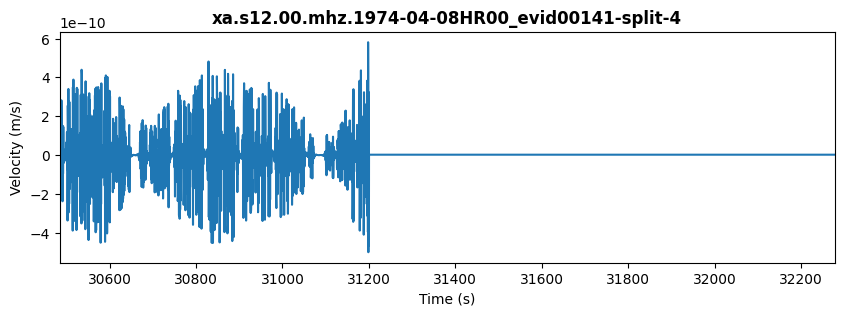

In [82]:
rand_idx = np.random.randint(len(dataframes_for_training))
filename_chunk, chunks_from_file = dataframes_for_training[rand_idx]
rand_chunk = np.random.randint(len(chunks_from_file))
data_cat = chunks_from_file[-1]

csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

print(csv_data.shape) # Shape must match the data Chunk Size set above

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{filename_chunk}-split-{rand_chunk}', fontweight='bold')

#####  Checking if chunks sizes match with our defined Data Chunk Size

In [83]:
defined_chunk_size = 11880

for filename_chunk, chunks_from_file in dataframes_for_training:
    for chunk_ in chunks_from_file:
        if len(chunk_) != defined_chunk_size:
            print(f"{filename_chunk} does not match")
        

#### Saving Normal Dataset for training

In [84]:
import os

def save_dataframes_as_csv(dataframes, folder_path, file_name_for_path):
    """
    Saves a list of Pandas DataFrames as CSV files.
    
    Parameters:
    dataframes (list): List of Pandas DataFrames to save.
    folder_path (str): Folder where the CSV files will be saved.
    """
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Iterate through the list of DataFrames and save each one as a CSV file
    sample_number = 1
    with tqdm(total=len(dataframes)) as pbar:
        for df in dataframes:
            # Create a unique filename for each DataFrame (e.g., file_1.csv, file_2.csv)
            file_name = f"{file_name_for_path}_{sample_number}.csv"
            file_path = os.path.join(folder_path, file_name)
            
            # Save the DataFrame as a CSV file
            df.to_csv(file_path, index=False)  # Set index=False to avoid writing the index as a column
            # print(f"Saved {file_name} to {folder_path}")
            sample_number += 1
            pbar.update(1)

folder_path = './data/lunar/training/cuts-vae'  # Replace with your target folder path

for filename_chunk, chunk in dataframes_for_training:
    # Call the function to save the DataFrames as CSV files
    save_dataframes_as_csv(chunk, folder_path, filename_chunk)
            


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 43.98it/s]


#### Saving Anomalies for testing after training

In [88]:
sampling_rate = 6.6  # 6.6Hz - sampling rate for the dataset
chunk_duration = 3600.0/2  # 30 minutes per chunk 3600s(1h)/2 = 30min

dataframes_for_anomalies = []
with tqdm(total=len(annomaly_quake)) as pbar:
    for filename, dataframe in annomaly_quake:
        # print(filename, dataframe)
        # Split the DataFrame into 1-second chunks based on the velocity column
        chunks = split_data_into_chunks(dataframe, sampling_rate, chunk_duration, column_name='velocity(m/s)')
        # Getting only the 2 first chunks, since most anomalies will happen mainly in first 30minutes after the label
        chunks = chunks[0:2]
        print(len(chunks))
        dataframes_for_anomalies.append([filename, chunks])
        pbar.update(1)

folder_path = './data/lunar/training/anomalies-vae'  # Replace with your target folder path

for filename_chunk, chunk in dataframes_for_anomalies:
    # Call the function to save the DataFrames as CSV files
    save_dataframes_as_csv(chunk, folder_path, filename_chunk)


  4%|██▌                                                             | 3/76 [00:00<00:02, 27.38it/s]

Total number of rows in DataFrame: 85477
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 488141
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 88653
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 543000
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 226983
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 119268
Samples per chunk: 11880
Adding new values for incomplete last chunk.


 14%|█████████                                                      | 11/76 [00:00<00:01, 36.51it/s]

2
Total number of rows in DataFrame: 95025
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 450776
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 292571
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 96615
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 297747
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 266336
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 396720
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 81908
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 198363
Samples per chunk: 11880
Adding new values for 

 28%|█████████████████▍                                             | 21/76 [00:00<00:01, 39.84it/s]

2
Total number of rows in DataFrame: 215070
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 134775
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 484166
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 207522
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 264364
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 403878
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 379619
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 339869
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 500861
Samples per chunk: 11880
Adding new values f

 34%|█████████████████████▌                                         | 26/76 [00:00<00:01, 31.62it/s]

2
Total number of rows in DataFrame: 39773
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 313645
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 358941
Samples per chunk: 11880
Adding new values for incomplete last chunk.


 45%|████████████████████████████▏                                  | 34/76 [00:00<00:01, 34.01it/s]

2
Total number of rows in DataFrame: 493296
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 139919
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 441243
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 470241
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 415405
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 143099
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 248436
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 186426
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 385574
Samples per chunk: 11880
Adding new values f

 61%|██████████████████████████████████████▏                        | 46/76 [00:01<00:00, 44.93it/s]

2
Total number of rows in DataFrame: 515575
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 139935
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 382394
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 509594
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 23467
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 554905
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 399486
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 151180
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 109970
Samples per chunk: 11880
Adding new values fo

 78%|████████████████████████████████████████████████▉              | 59/76 [00:01<00:00, 52.47it/s]

2
Total number of rows in DataFrame: 128789
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 137132
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 506410
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 118473
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 551725
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 11522
Samples per chunk: 11880
1
Total number of rows in DataFrame: 279453
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 15520
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 420970
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of row

 86%|█████████████████████████████████████████████████████▉         | 65/76 [00:01<00:00, 47.41it/s]

2
Total number of rows in DataFrame: 167735
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 365711
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 129571
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 350581
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 231328
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 563280
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 502053
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 232946
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 551745
Samples per chunk: 11880
Adding new values f

100%|███████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 42.33it/s]


2
Total number of rows in DataFrame: 284235
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 149875
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 137160
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 331930
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 189618
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2
Total number of rows in DataFrame: 491317
Samples per chunk: 11880
Adding new values for incomplete last chunk.
2


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 42.59it/s]
